In [103]:
import ROOT, rat
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 

import jp_mpl as jplot

from matplotlib.colors import LogNorm
import pickle
import ratdb_reader
reload(ratdb_reader)

<module 'ratdb_reader' from '/home/jpyanez/snoplus/snoplus_python/ratdb_reader.pyc'>

In [104]:
# Airplane mode
db = rat.RAT.DB.Get()
db.SetAirplaneModeStatus(True)
db.SetDefaultPlaneLockStatus(False)
print 'This is AIRPLANE MODE - be careful!'

This is AIRPLANE MODE - be careful!


In [105]:
infile_name = '/home/jpyanez/snoplus/software/rat/data/PMTTRANSIT.ratdb'
dbdata = ratdb_reader.dbreader(infile_name)

reader: Creating a dict in line 4
reader: Closing a dict in line 17
reader: Creating a dict in line 19
reader: Closing a dict in line 34


In [106]:
socdir = '/sb/project/qbs-015-ac/jpyanez/data/SOC_files'

In [107]:
all_files = os.listdir(socdir)
print all_files

['SOC_0000017375_reprocessed.root', 'SOC_0000017376_reprocessed.root', 'SOC_0000017377_reprocessed.root', 'SOC_0000017378_reprocessed.root', 'SOC_0000017384_reprocessed.root', 'SOC_0000017386_reprocessed.root', 'SOC_0000100554.root', 'SOC_0000100555.root', 'SOC_0000100556.root', 'SOC_0000100558.root', 'SOC_0000100559.root', 'SOC_0000100560.root', 'SOC_0000101152.root', 'SOC_0000101153.root', 'SOC_0000101154_000.root', 'SOC_0000101154_001.root', 'SOC_0000101154_002.root', 'SOC_0000101154_003.root', 'SOC_0000101154_004.root', 'SOC_0000101155.root', 'SOC_0000101158.root', 'SOC_0000101159.root', 'SOC_0000101160.root', 'SOC_0000101161.root', 'SOC_0000101427_reprocessed_newPCA.root', 'SOC_0000101428_reprocessed_newPCA.root', 'SOC_0000101432_reprocessed_newPCA.root', 'SOC_0000101433_reprocessed_newPCA.root', 'SOC_0000101437_reprocessed_newPCA.root', 'SOC_0000102518.root', 'SOC_0000102521.root', 'SOC_0000102523.root', 'SOC_0000102526.root', 'SOC_0000102529.root', 'SOC_0000102552.root', 'SOC_00

In [124]:
def plotPMTtoa(time_array,
               bin_width   = 0.5, # in ns
               time_window = 400.,
               start_time  = -100,
              color = 'b'):

    residual_axis = np.arange(start_time, time_window + start_time+ bin_width/2., bin_width)

    counts, x = np.histogram(time_array, residual_axis)
    
    mytime  = np.linspace(-10, 80, 1001)
    mylatep = lpfcn(mytime)
    print mytime
    

    plt.plot(0.5+mytime+residual_axis[counts.argmax()]-mytime[mylatep.argmax()], 
             mylatep*counts.max()*1./mylatep.max(), '--k')

    jplot.unfilledBar(residual_axis, counts, color=color)
    plt.xlabel('Time of arrival (ns)', fontsize='x-large')
    plt.ylabel('Counts')
    plt.yscale('log')

In [226]:
run_of_interest = '102529'
file_of_interest = [x for x in all_files if run_of_interest in x]
print file_of_interest

['SOC_0000102529.root']


In [227]:
# Get the soc object
reader = rat.socreader(os.path.join(socdir, file_of_interest[0]))
soc, run = reader.next()
print 'RUN info'
print 'manip position', np.array(soc.calib.GetPos())
print 'socfit position', np.array(soc.GetFitResult(soc.GetFitNames()[0]).GetVertex(0).GetPosition())
print 'wavelength', soc.calib.GetMode()

RUN info
manip position [   0. -254.   25.]
socfit position [ -10.89273453 -216.66325378   32.9556427 ]
wavelength 419


In [228]:
xdata = dbdata['r1408']['x'][1:]
xtest = np.linspace(-10, 80, 301)
ydata = 1000.*(dbdata['r1408']['y'][1:] - dbdata['r1408']['y'][:-1])
lpfcn = interpolate.InterpolatedUnivariateSpline(xdata, 
                                                 ydata)


In [229]:
lpfcn_roots = interpolate.InterpolatedUnivariateSpline(xdata, 
                                                 ydata-ydata.max()/2.)
r1,r2 = lpfcn_roots.roots()
print r2-r1

3.77044789207


[-10.    -9.91  -9.82 ...,  79.82  79.91  80.  ]


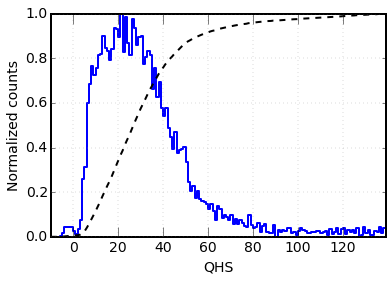

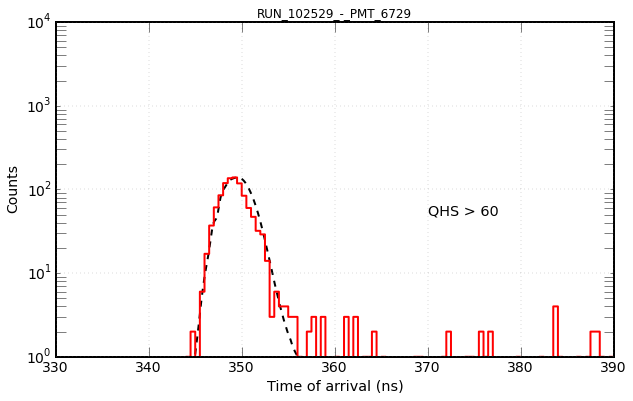

In [231]:
one_pmt = 6729

bigger_than = 60

time_array = np.array(soc.GetSOCPMT(one_pmt).GetTimes())
qhs_array  = np.array(soc.GetSOCPMT(one_pmt).GetQHSs())

xqhs = np.arange(-10, 140, 1)
qhs, x = np.histogram(qhs_array, xqhs)
jplot.unfilledBar(xqhs, qhs*1./qhs.max())
plt.plot(xqhs[:-1], np.cumsum(qhs)*1./np.sum(qhs), '--k')
plt.xlabel('QHS')
plt.ylabel('Normalized counts')

plt.figure(figsize=(10,6))
#plotPMTtoa(time_array,
#          start_time=300)
plotPMTtoa(time_array[qhs_array > bigger_than],
          start_time=300, color = 'red')


str_name = 'RUN_' + run_of_interest + '_-_PMT_' +  "%i" % one_pmt
plt.title(str_name)
plt.xlim([330,390])
plt.ylim([1, 10**4])
plt.text(370, 50, 'QHS > ' + "%i" % bigger_than, fontsize='x-large')
plt.savefig('/home/jpyanez/snoplus/data/SOC_quick_checks/' + str_name + '_BiggerThan'+ "%i" % bigger_than +'.png')